<a href="https://colab.research.google.com/github/chobocoding/deeplearning/blob/main/LSGAN(MNIST)%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


In [2]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'
print(device)

cuda


In [3]:
z_size = 100
middle_size = 500
batch_size = 256
learning_rate = 0.0001
epoch = 50

In [4]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist_train = dset.MNIST('./', train=True, transform=transforms_train,
                         target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                           shuffle=True, num_workers=2, drop_last=True)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()       

        self.layer1 = nn.Sequential(
            nn.Linear(z_size, 200),
            nn.ReLU(),
            nn.Linear(200, 256),
            nn.ReLU(),
            nn.Linear(256, middle_size),
            nn.BatchNorm1d(middle_size),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(middle_size, 784),
            nn.Tanh()
        )
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = out.view(batch_size, 1, 28, 28)
        return out

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, middle_size),
            nn.LeakyReLU(),
            nn.Linear(middle_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 32),
            nn.LeakyReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(32, 1)
        )


    def forward(self, z):
        out = z.view(batch_size, -1)
        out = self.layer1(out)
        out = self.layer2(out)            
        return out   

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [8]:
loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

ones_label = torch.ones(batch_size, 1).to(device)
zeros_label = torch.zeros(batch_size, 1).to(device)

In [9]:
for i in range(epoch):
    for j, (image, label) in enumerate(train_loader):
        image = image.to(device)
        # 구분자 학습
        dis_optim.zero_grad()
        z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=1).to(device)

        # 생성 후 입력
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)

        dis_real = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake, zeros_label)) + torch.sum(loss_func(dis_real, ones_label))
        dis_loss.backward(retain_graph=True)
        dis_optim.step()

        # 생성자 학습
        gen_optim.zero_grad()

        z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=1).to(device)
        # 생성 후 입력
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)

        gen_loss = torch.sum(loss_func(dis_fake, ones_label))
        gen_loss.backward()
        gen_optim.step()

    # model save
    if i % 5 == 0:
        print(gen_loss,dis_loss)
        # torch.save([generator,discriminator],'./model/vanilla_gan.pkl')            
        v_utils.save_image(gen_fake.cpu().data[0:25],"batchnorm/gen_{}.png".format(i), nrow=5)
        print("{}th epoch gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))

tensor(0.5200, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2078, device='cuda:0', grad_fn=<AddBackward0>)
0th epoch gen_loss: 0.5199640393257141 dis_loss: 0.2077760398387909
tensor(0.6495, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)
5th epoch gen_loss: 0.6495178937911987 dis_loss: 0.15822666883468628
tensor(0.7519, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)
10th epoch gen_loss: 0.7519385814666748 dis_loss: 0.16638721525669098
tensor(0.5665, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>)
15th epoch gen_loss: 0.5665454864501953 dis_loss: 0.19081108272075653
tensor(0.8510, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2567, device='cuda:0', grad_fn=<AddBackward0>)
20th epoch gen_loss: 0.850978672504425 dis_loss: 0.2567260265350342
tensor(0.8105, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3207, device='cuda:0', grad_fn

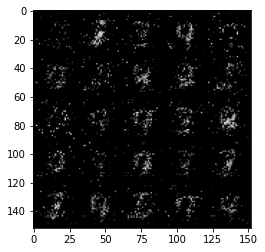

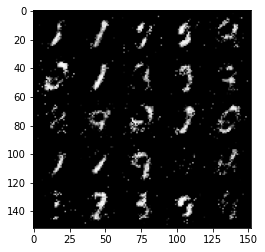

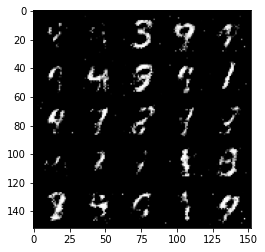

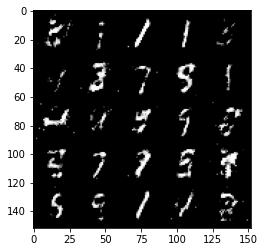

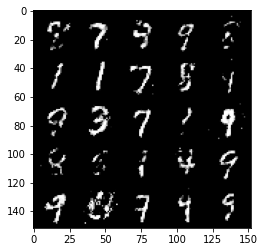

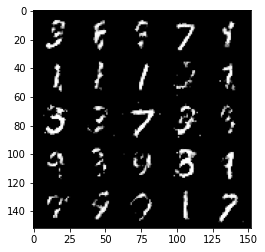

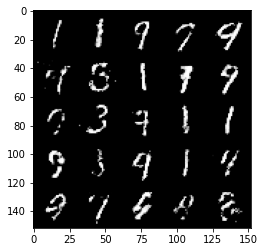

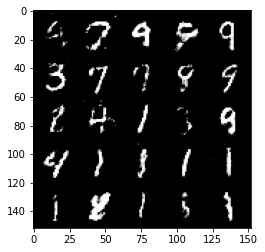

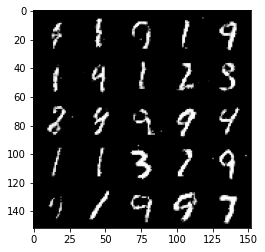

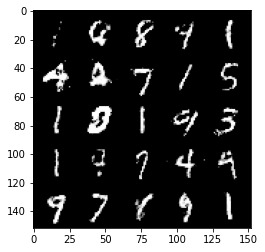

In [10]:
from glob import glob 

for i in range(epoch):
  file_list = glob("./batchnorm/gen_{}.png".format(i))
  img_per_epoch = len(file_list)
  for idx,j in enumerate(file_list):
    img = plt.imread(j)
    plt.subplot(1,img_per_epoch,idx+1)
    plt.imshow(img)
  plt.show()

In [11]:
z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=1).to(device)

In [12]:
fake_image = generator.forward(z)[7].reshape(28, 28)

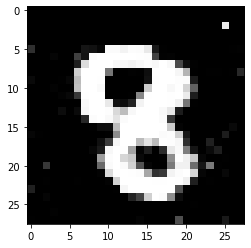

In [13]:
plt.imshow(fake_image.detach().cpu().numpy(), cmap='gray')